<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def edit_names_columns(df):
    
    """Переводит имена столбцов в нижний регистр, удаляет пробелы в начале и конце имени, 
    заменяет пробелы на знак нижнего подчеркивания"""
    
    df.columns = [x.lower().strip().replace(' ', '_') for x in df.columns]
    print(df.columns)

In [4]:
def primary_info(df):
    
    '''Расчитывает количество дубликатов и пропусков в данных, 
    выводит информацию о количественных и категориальных данных'''
    
    print(f'Количество пропусков:\n{df.isna().sum()}\n')
    print(f'Количество дубликатов: {df.duplicated().sum()}\n')
    print(f'Количественные признаки: {data.select_dtypes(include=[np.number]).columns.tolist()}\n')
    print(f'Категориальные признаки: {data.select_dtypes(exclude=[np.number]).columns.tolist()}\n')

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим и изучим данные и необходимые библиотеки

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore")

In [6]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)
except:
    data = pd.read_csv(r'C:\Users\norri\OneDrive\Рабочий стол\файлы для проектов\toxic_comments.csv', index_col = 0)
    
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [9]:
# Отредактируем имена столбцов
edit_names_columns(data)

Index(['text', 'toxic'], dtype='object')


In [10]:
# Проверим наличие пропусков и дубликатов
primary_info(data)

Количество пропусков:
text     0
toxic    0
dtype: int64

Количество дубликатов: 0

Количественные признаки: ['toxic']

Категориальные признаки: ['text']



In [11]:
# Проверим на уникальность значений 
data.toxic.unique()

array([0, 1])

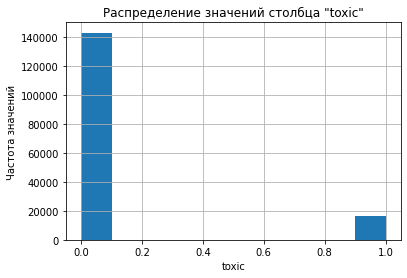

In [12]:
# Посмотрим на распределение частоты значений
data['toxic'].hist()
plt.title('Распределение значений столбца "toxic"')
plt.xlabel('toxic')
plt.ylabel('Частота значений')
plt.show()

In [13]:
# Инициализация WordNet Lemmatizer и загрузка списка стоп-слов
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Функция для лемматизации текста
def lemm_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)  # Удаление неалфавитных символов
    text = text.lower()  # Приведение текста к нижнему регистру
    token = nltk.word_tokenize(text)  # Токенизация текста
    tagged_words = nltk.pos_tag(token)  # Получение POS-тегов для каждого слова
    lemmatized_words = []
    for word, tag in tagged_words:
        pos_tag = get_wordnet_pos(tag)  # Получение соответствующего POS-тега для WordNet Lemmatizer
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos_tag)  # Лемматизация слова с учетом POS-тега
        lemmatized_words.append(lemmatized_word)
    lemmatized_text = ' '.join(lemmatized_words)  # Объединение лемматизированных слов в строку
    return lemmatized_text

In [15]:
# Утилитарная функция для определения POS-тега для WordNet Lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [17]:
tqdm.pandas()

data['lemm_text'] = data['text'].progress_apply(lemm_text)
data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [18]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [19]:
data_2 = data.copy()
y = data_2['toxic']
data_2 = data_2.drop(['toxic'], axis = 1)

Разделим данные на выборки

In [20]:
# Делим на выборки
x_train, x_test, y_train, y_test = train_test_split(data_2, y, test_size = 0.3, stratify = y)

In [21]:
print('Train data shape:', x_train.shape, y_train.shape)
print('Test data shape:', x_test.shape, y_test.shape)

Train data shape: (111504, 2) (111504,)
Test data shape: (47788, 2) (47788,)


Данные обработали:
Проверили наличие пропусков и дубликатов, отредактировали имена столбцов.
Есть большой дисбаланс классов.
Очистили от лишних символов, лемматизировали и векторизировали.

## Обучение

Проверим классификацию тональности текста

In [22]:
# функция для обучения модели
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(x_train['lemm_text'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [23]:
# Обучение Логической модели
LR_model = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7779550812327385
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [24]:
# Обучение дерева
DTC_model = training(DecisionTreeClassifier(), {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]})

Лучший результат: 0.5338341321970923
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}


In [25]:
# Обучение CatBoost
CBC_model = training(CatBoostClassifier(logging_level='Silent'), {'model__depth': [4,6],
                 'model__learning_rate' : [0.01,0.03],
                  'model__iterations' : [10, 50]})

Лучший результат: 0.5055086669814767
Лучшие параметры: {'model__depth': 6, 'model__iterations': 50, 'model__learning_rate': 0.03}


Так как нам важна точность предсказаний, лучший результат показала модель LogisticRegressiоn.
Проверим на тестовой выборке.

In [26]:
# предсказание тестовой выборки
res = f1_score(y_test, LR_model.predict(x_test['lemm_text']))

In [27]:
print("Результат LogisticRegression", res)

Результат LogisticRegression 0.780980820029861


## Выводы

Согласно результату тестирования нужная метрика достигнута на модели LogisticRegression с L2-регуляризацией

Рекомендация: проверить еще раз выбор модель CatBoost с большим количеством итераций и большим количеством шагов на более мощном оборудование. Возможно результат поменяется.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны